# Classification Example
## pytorch model export to onnx model 

In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as trns
from PIL import Image
import time
import numpy as np
import warnings
warnings.simplefilter("ignore")


# https://pytorch.org/vision/stable/models.html
# 選一個模型，torchvision loading
# Load model
# You will see a similar message, if first time loading:
# Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/rowantseng/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
model = models.mobilenet_v2(pretrained=True)
dummy_inpurt = torch.rand(1,3,224,224)
out=model(dummy_inpurt)
torch.onnx.export(model, dummy_inpurt, './mobilenetv2.onnx', opset_version=11, example_outputs=out)
print('got')

got


# load onnx model and inference

In [2]:
import onnxruntime as ort 
import matplotlib.pyplot as plt

onnxmodel_path='./mobilenetv2.onnx'
image_paths = ['images/Car.jpg',
              'images/cat.jpg',
              'images/Dog.jpg',
              'images/Cruise-ships-1.png',
              'images/wheel.png',
              'images/CatDog1.jpg',
              'images/CatDog2.jpg',
              'images/CatDog3.jpg',]
class_def = 'imagenet_classes.txt'


# Run the model on the backend
session = ort.InferenceSession(onnxmodel_path, None)
# get the name of the first input of the model
input_name = session.get_inputs()[0].name  
print('Input Name:', input_name)

test_data_num=1


Input Name: input.1


In [3]:

# Load ImageNet classes
with open(class_def) as f:
    classes = [line.strip() for line in f.readlines()]

# Define image transforms
transforms = trns.Compose([trns.Resize((224, 224)), trns.ToTensor(), trns.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

Output size:(1, 1000)


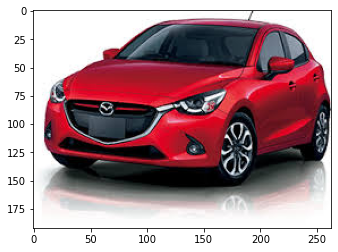

Inference results:
Label 817: sports car, sport car (0.975869) 

Label 511: convertible (0.007087) 

Label 751: racer, race car, racing car (0.005766) 

##################################################
Output size:(1, 1000)


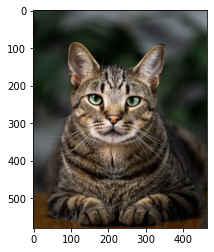

Inference results:
Label 281: tabby, tabby cat (0.622207) 

Label 282: tiger cat (0.192830) 

Label 285: Egyptian cat (0.161235) 

##################################################
Output size:(1, 1000)


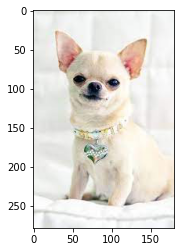

Inference results:
Label 151: Chihuahua (0.970031) 

Label 158: toy terrier (0.012503) 

Label 245: French bulldog (0.007342) 

##################################################
Output size:(1, 1000)


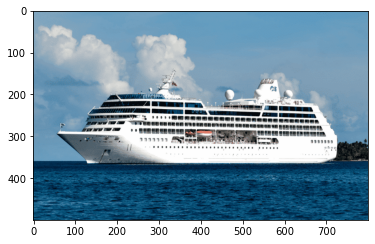

Inference results:
Label 628: liner, ocean liner (0.999862) 

Label 694: paddlewheel, paddle wheel (0.000064) 

Label 484: catamaran (0.000022) 

##################################################
Output size:(1, 1000)


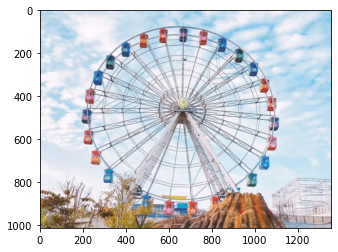

Inference results:
Label 417: balloon (0.303779) 

Label 701: parachute, chute (0.162069) 

Label 755: radio telescope, radio reflector (0.154412) 

##################################################
Output size:(1, 1000)


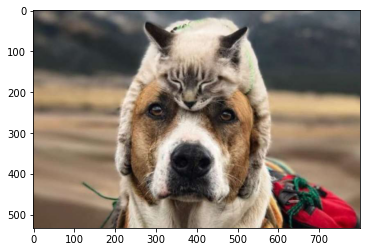

Inference results:
Label 273: dingo, warrigal, warragal, Canis dingo (0.183241) 

Label 248: Eskimo dog, husky (0.145279) 

Label 253: basenji (0.080462) 

##################################################
Output size:(1, 1000)


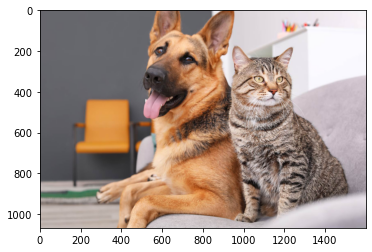

Inference results:
Label 235: German shepherd, German shepherd dog, German police dog, alsatian (0.866407) 

Label 225: malinois (0.031248) 

Label 174: Norwegian elkhound, elkhound (0.014210) 

##################################################
Output size:(1, 1000)


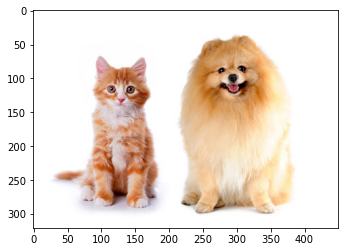

Inference results:
Label 259: Pomeranian (0.760022) 

Label 157: papillon (0.046261) 

Label 283: Persian cat (0.026509) 

##################################################


In [4]:
for image_path in image_paths:
    # Read image and run prepro
    image = Image.open(image_path).convert("RGB")
    image_tensor = transforms(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_np = image_tensor.numpy()

    # model run
    outputs = session.run([], {input_name: image_np})[0] 
    print("Output size:{}".format(outputs.shape))


    # Result postprocessing
    idx = np.argmax(outputs)
    sort_idx = np.flip(np.squeeze(np.argsort(outputs)))
    idx = np.argmax(outputs)

    # outputs = np.sort(outputs[0,:])
    probs = postprocess(outputs)
    
    plt.imshow(image)
    plt.show()
    top_k=3
    print("Inference results:")
    for index in sort_idx[:top_k]:
        print("Label {}: {} ({:5f}) \n".format(index, classes[index],probs[index] ))
    print('#'*50)